<a href="https://colab.research.google.com/github/BALAMANIKANTA29/Fmml__labs__projects__assginments/blob/main/Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2025-04-20 08:06:38--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 3.165.102.31, 3.165.102.62, 3.165.102.113, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.165.102.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  --.-KB/s    in 0.1s    

2025-04-20 08:06:38 (332 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


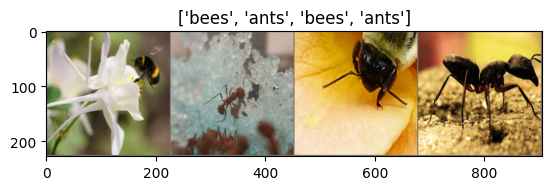

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5609 Acc: 0.6926

Epoch 1/4
----------
Loss: 0.6521 Acc: 0.7418

Epoch 2/4
----------
Loss: 0.5115 Acc: 0.7582

Epoch 3/4
----------
Loss: 0.5500 Acc: 0.7869

Epoch 4/4
----------
Loss: 0.5497 Acc: 0.7787



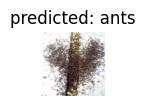

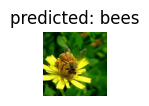

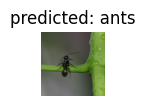

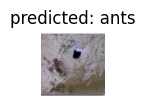

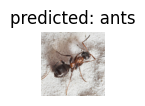

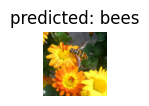

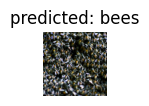

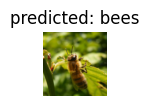

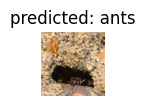

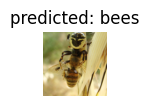

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


Here’s an essay-style response addressing each of the three questions in depth:

---

### 1) **Significance of Using Data Augmentations Like Resize, Crop, etc. on Training Data**

Data augmentation plays a crucial role in improving the performance and generalization of deep learning models, especially in computer vision tasks. Techniques such as resizing, random cropping, flipping, rotation, and color jittering artificially increase the diversity of the training dataset by creating modified versions of the existing images.

The primary benefit of these augmentations is that they help the model become invariant to small changes in the input, such as shifts, rotations, and scaling, which might occur naturally in real-world data. For example, in an image classification task like distinguishing between ants and bees, the object might appear in different parts of the image or at different scales. Random cropping ensures that the model doesn’t become overly reliant on the object being centered or at a specific size.

Additionally, augmentations act as a form of **regularization**, reducing the risk of overfitting—particularly important when the training dataset is small. Without augmentations, the model may memorize specific features of the training images rather than learning generalizable patterns. In essence, data augmentation teaches the model to focus on the essential and consistent parts of the object regardless of minor changes, thus enhancing its robustness and performance on unseen data.

---

### 2) **Performance Without Using a Pretrained ResNet Model**

When training a ResNet model **without using pretrained weights** (i.e., `pretrained=False`), the model starts learning from random initialization. In this case, it has no prior knowledge of image features and must learn everything from scratch solely based on the limited training data available.

In tasks such as ants vs bees classification—where the dataset is relatively small—training a model from scratch often leads to **significantly lower performance** compared to using a pretrained model. The model may struggle to converge properly, and even if it does, it will likely exhibit **higher training and validation loss** and **lower accuracy**, especially on the validation/test set. This is because the model lacks the extensive feature hierarchy that pretrained networks have already learned from large-scale datasets like ImageNet.

Thus, without a pretrained model, the performance typically degrades due to insufficient data to support effective training of a deep neural network.

---

### 3) **Effectiveness of Using a Pretrained Model from a Different Dataset**

If the ResNet model was pretrained on a dataset **significantly different** from the ants vs bees dataset, the performance may still be reasonably good, though not as optimal as a model pretrained on a similar dataset. The reason is that the **early layers of CNNs learn generic features** such as edges, textures, and simple shapes, which are **common across a wide variety of images** regardless of the specific objects.

These early features are highly transferable and beneficial for most vision tasks. Even if the higher-level features are not directly relevant to the new dataset, they provide a strong starting point. By freezing some of the early layers and fine-tuning the later layers, we can adapt the model to the new task effectively.

However, if the pretraining dataset is *drastically different* (e.g., medical imaging or satellite imagery), the performance might not be as high because the domain gap becomes larger. In such cases, more aggressive fine-tuning may be necessary, and performance gains might be smaller. But generally, **a pretrained model—even from a different domain—tends to outperform a model trained from scratch** when data is limited.

---

Let me know if you'd like to see example code or comparisons of training from scratch vs pretrained!